In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import prepare_data, PINN_NBody, PINN_NBody_unk

In [29]:
# physical constants
G = 1.4880826e-34
masses = np.array([
    1.988544e30, 3.302e23, 48.685e23, 6.0477246e24, 6.4185e23,
    1898.13e24, 5.68319e26, 86.8103e24, 102.41e24, 1.4639248e+22
], dtype=float)
N = len(masses)

df = pd.read_csv("state.csv")
df = df.iloc[:100]
data = df.values
t_data = data[:, 0:1].astype(np.float32)  # time
state_data = data[:, 1:].astype(np.float32)  # positions + velocities

# We will predict Earth (index 3)
earth_idx = 3
# Known bodies: all except Earth
known_idx = [i for i in range(N) if i != earth_idx]

X, Y = prepare_data(state_data, N, known_idx)
t_tensor = torch.tensor(t_data, dtype=torch.float32)
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# we initialize the model and optimizer
input_dim = X.shape[1]  # known bodies positions and velosities
output_dim = Y.shape[1] # full state

In [30]:
import os
save_dir = "results"
os.makedirs(save_dir, exist_ok=True)

Epoch 0, Total Loss=2.031e-02, Data Loss=7.630e-03, Phys Loss=1.268e-02
Epoch 200, Total Loss=5.543e-05, Data Loss=1.080e-05, Phys Loss=4.463e-05
Epoch 400, Total Loss=3.568e-05, Data Loss=7.872e-06, Phys Loss=2.781e-05
Epoch 600, Total Loss=3.135e-05, Data Loss=7.318e-06, Phys Loss=2.403e-05
Epoch 800, Total Loss=2.976e-05, Data Loss=7.157e-06, Phys Loss=2.260e-05
Epoch 1000, Total Loss=2.900e-05, Data Loss=7.095e-06, Phys Loss=2.191e-05
Epoch 1200, Total Loss=2.859e-05, Data Loss=7.068e-06, Phys Loss=2.152e-05
Epoch 1400, Total Loss=2.833e-05, Data Loss=7.053e-06, Phys Loss=2.128e-05
Epoch 1600, Total Loss=3.072e-05, Data Loss=9.073e-06, Phys Loss=2.164e-05
Epoch 1800, Total Loss=2.804e-05, Data Loss=7.039e-06, Phys Loss=2.100e-05


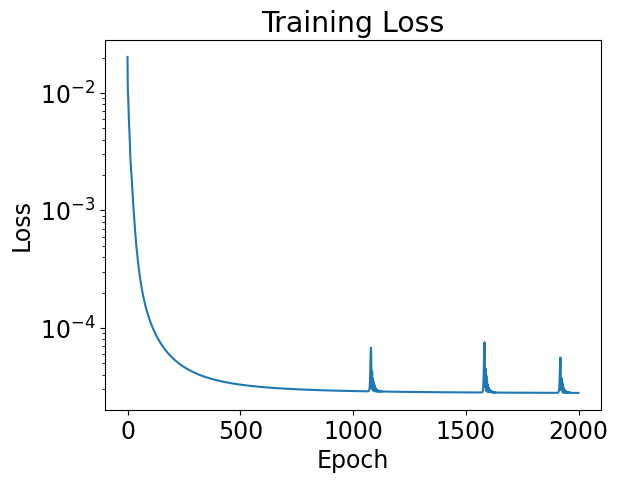

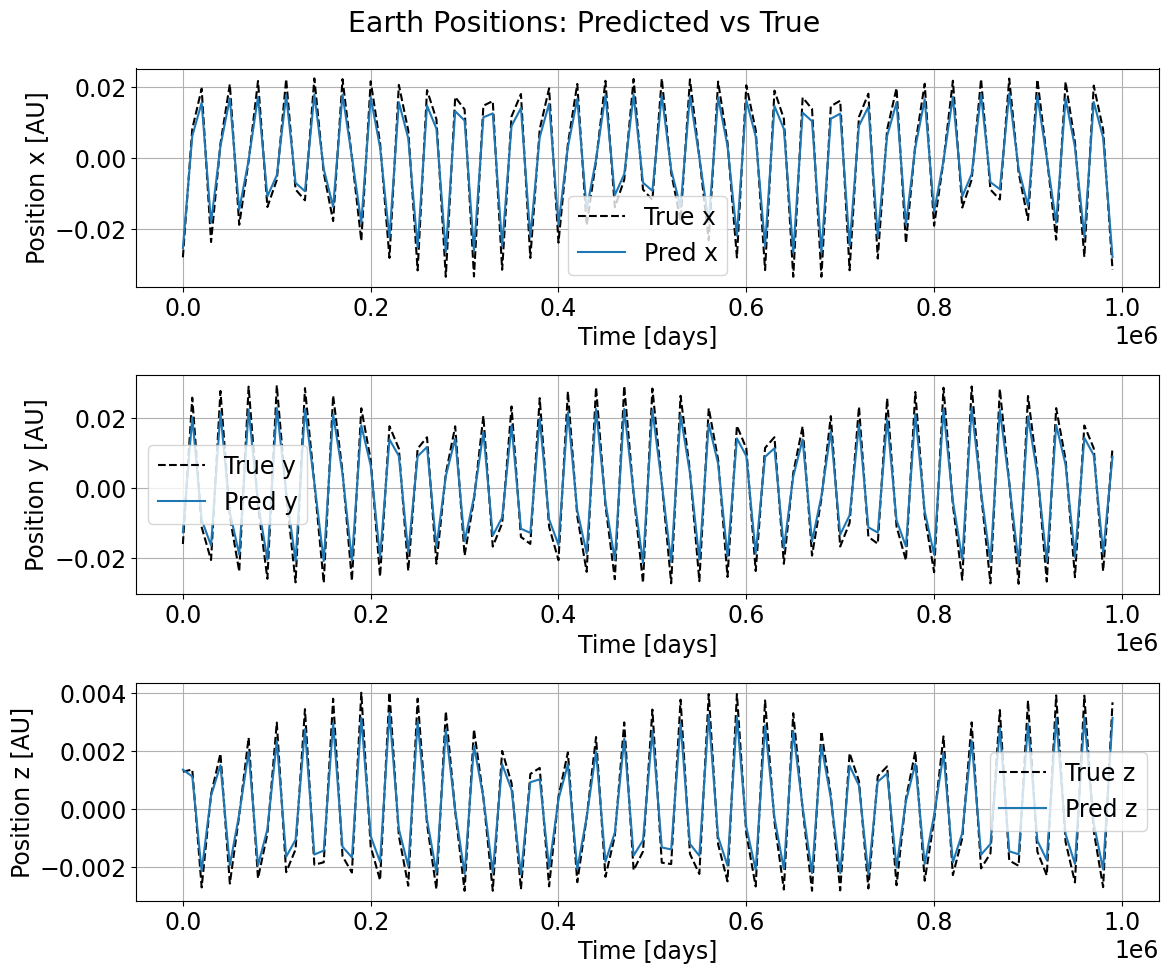

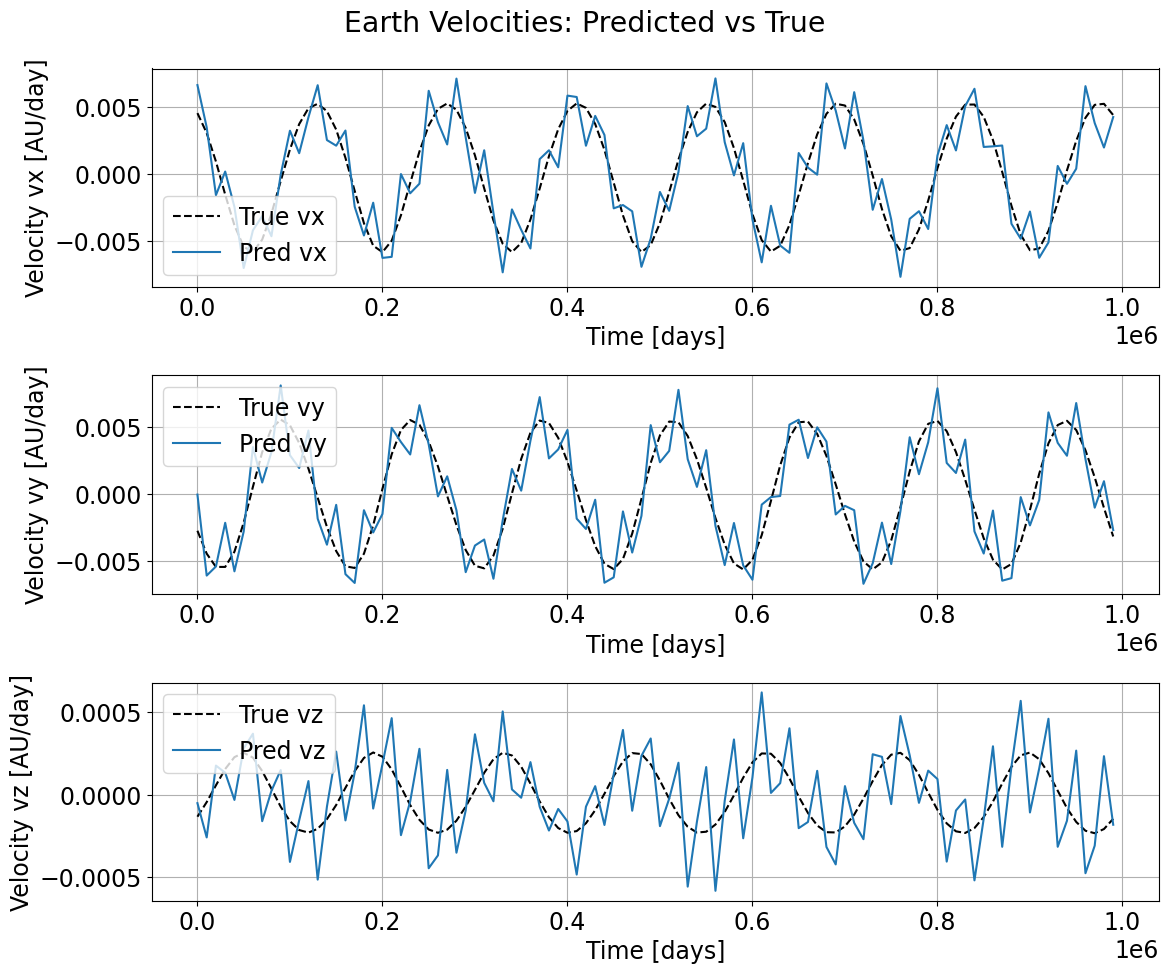

In [31]:
# introduce the n-body class
model = PINN_NBody(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# train
epochs = 2000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss, loss_data, loss_phys = model.loss_fn(y_pred, Y_tensor, earth_idx, N, masses, G)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Total Loss={loss.item():.3e}, Data Loss={loss_data.item():.3e}, Phys Loss={loss_phys.item():.3e}")

plt.rcParams.update({'font.size': 17}) 

# loss plot
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

earth_pos_true = state_data[:, earth_idx*3:(earth_idx+1)*3]
earth_vel_true = state_data[:, 3*N + earth_idx*3: 3*N + (earth_idx+1)*3]


y_pred = model(X_tensor).detach().numpy()
earth_pos_pred = y_pred[:, earth_idx*3:(earth_idx+1)*3]
earth_vel_pred = y_pred[:, 3*N + earth_idx*3: 3*N + (earth_idx+1)*3]

# plot predicted Earth positions vs true
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
components = ["x", "y", "z"]
for i, comp in enumerate(components):
    axs[i].plot(t_data, earth_pos_true[:, i], 'k--', label=f"True {comp}")
    axs[i].plot(t_data, earth_pos_pred[:, i], label=f"Pred {comp}")
    axs[i].set_xlabel("Time [days]")
    axs[i].set_ylabel(f"Position {comp} [AU]")
    axs[i].legend()
    axs[i].grid(True)
fig.suptitle("Earth Positions: Predicted vs True")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'earth_pos_pinn_kn'))
plt.show()

# plot predicted Earth velocities vs true
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
components = ["vx", "vy", "vz"]
for i, comp in enumerate(components):
    axs[i].plot(t_data, earth_vel_true[:, i], 'k--', label=f"True {comp}")
    axs[i].plot(t_data, earth_vel_pred[:, i], label=f"Pred {comp}")
    axs[i].set_xlabel("Time [days]")
    axs[i].set_ylabel(f"Velocity {comp} [AU/day]")
    axs[i].legend()
    axs[i].grid(True)
fig.suptitle("Earth Velocities: Predicted vs True")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'earth_vel_pinn_kn'))
plt.show()


Epoch    0 | Total Loss=3.212e-02, Data Loss=8.496e-03, Phys Loss=2.363e-02
Epoch  200 | Total Loss=2.437e-04, Data Loss=3.820e-05, Phys Loss=2.055e-04
Epoch  400 | Total Loss=9.406e-05, Data Loss=1.678e-05, Phys Loss=7.728e-05
Epoch  600 | Total Loss=6.024e-05, Data Loss=1.124e-05, Phys Loss=4.899e-05
Epoch  800 | Total Loss=4.700e-05, Data Loss=9.197e-06, Phys Loss=3.780e-05
Epoch 1000 | Total Loss=4.036e-05, Data Loss=8.269e-06, Phys Loss=3.209e-05
Epoch 1200 | Total Loss=3.658e-05, Data Loss=7.791e-06, Phys Loss=2.879e-05
Epoch 1400 | Total Loss=3.424e-05, Data Loss=7.521e-06, Phys Loss=2.672e-05
Epoch 1600 | Total Loss=3.269e-05, Data Loss=7.357e-06, Phys Loss=2.533e-05
Epoch 1800 | Total Loss=3.161e-05, Data Loss=7.254e-06, Phys Loss=2.436e-05
G_learned   = 1.442532e-34
G_true      = 1.488083e-34

Masses (learned vs true):
Body 0:  learned = 1.965553e+30   |   true = 1.988544e+30
Body 1:  learned = 3.435405e+23   |   true = 3.302000e+23
Body 2:  learned = 4.112632e+24   |   true 

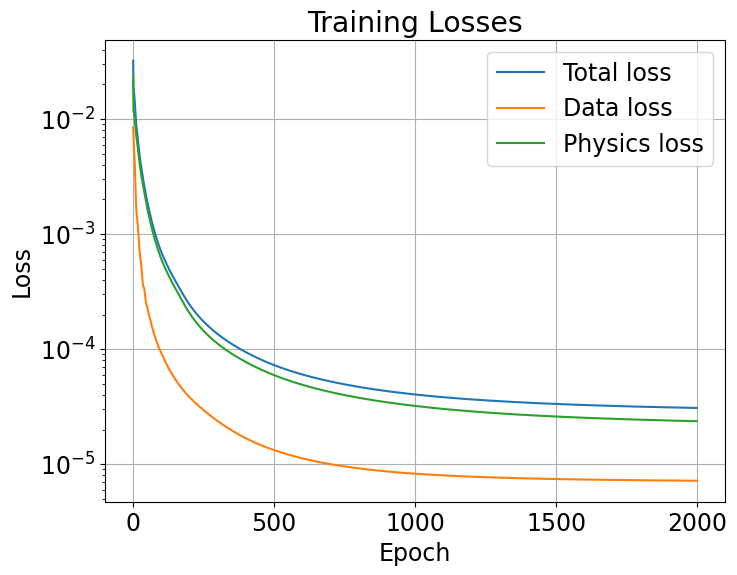

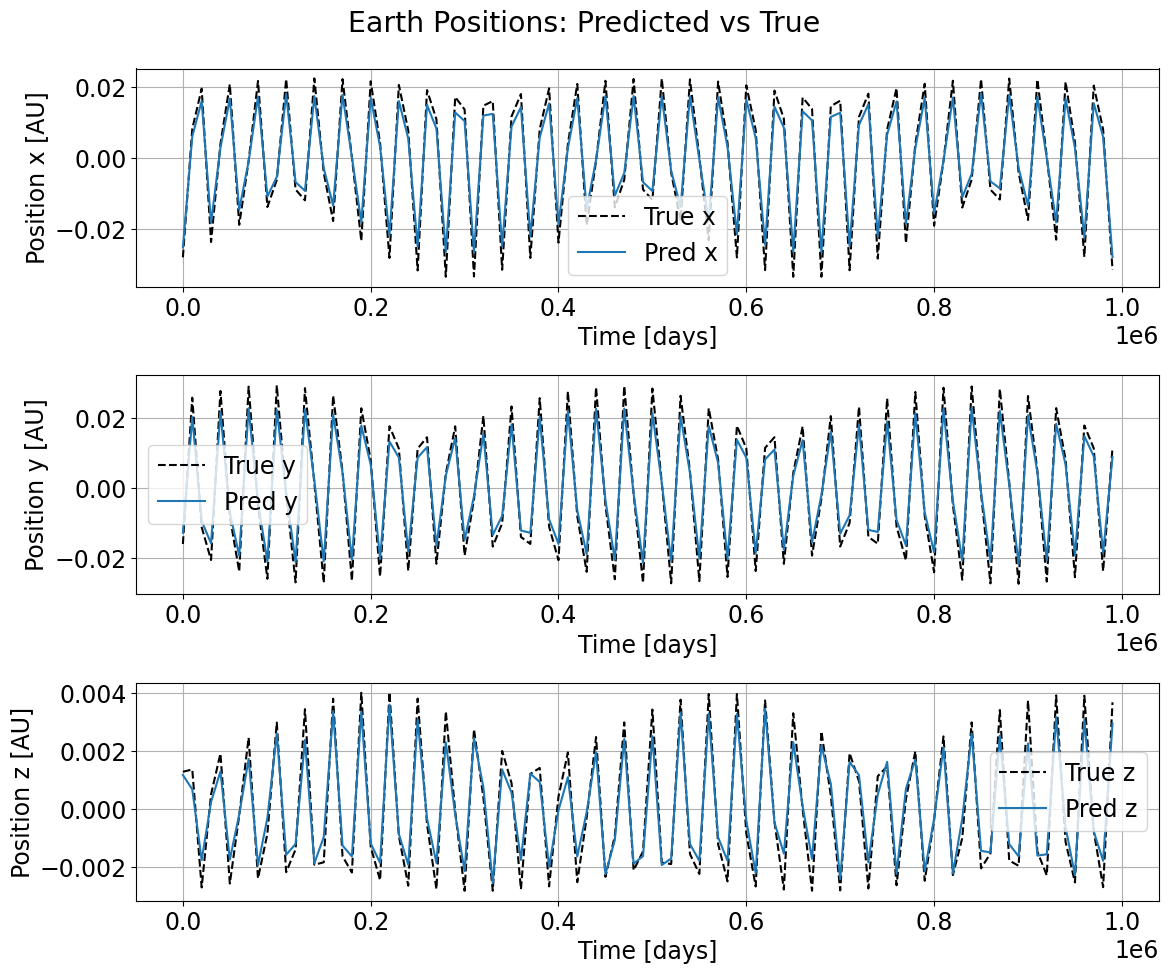

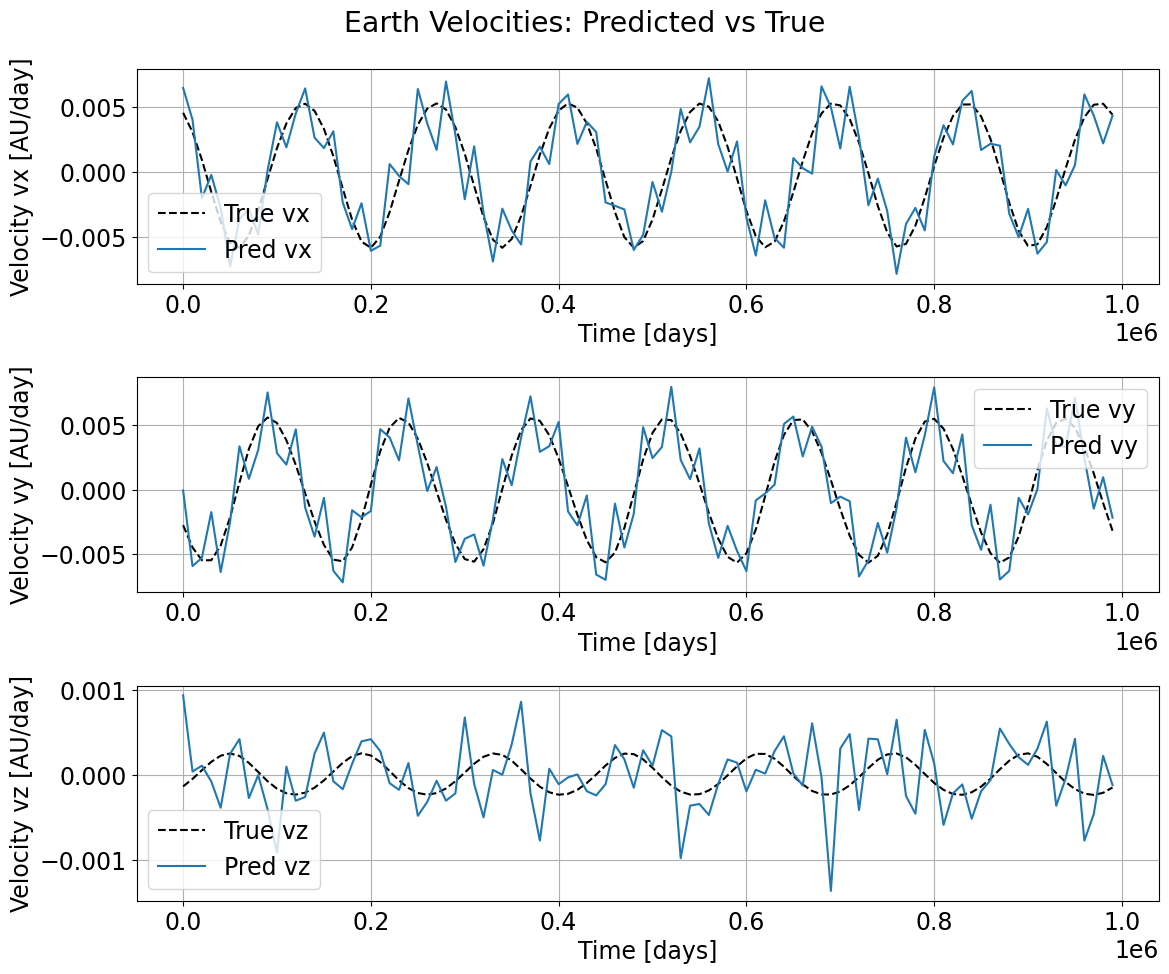

In [32]:
# introduce noisy G and masses for the coefficients initializations:
sigma_G = 0.01      # 1% noise on G
sigma_m = 0.05      # 5% noise on masses

G_noisy = G * (1 + sigma_G * np.random.randn())
masses_noisy = masses * (1 + sigma_m * np.random.randn(len(masses)))
# introduce n-body PINN model
model = PINN_NBody_unk(input_dim, output_dim, G_initial=G_noisy, masses_initial=masses_noisy)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
epochs = 2000
λ_phys = 1.0
loss_history = []
data_loss_history = []
phys_loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss, loss_data, loss_phys = model.loss_fn(y_pred, Y_tensor, N, earth_idx, λ_phys=λ_phys)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    data_loss_history.append(loss_data.item())
    phys_loss_history.append(loss_phys.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | "
              f"Total Loss={loss.item():.3e}, "
              f"Data Loss={loss_data.item():.3e}, "
              f"Phys Loss={loss_phys.item():.3e}")

# Print learned physical parameters
G_learned, masses_learned = model.get_physical_params()

print(f"G_learned   = {G_learned:.6e}")
print(f"G_true      = {G:.6e}")
print("\nMasses (learned vs true):")
for i, (m_l, m_t) in enumerate(zip(masses_learned, masses)):
    print(f"Body {i}:  learned = {m_l:.6e}   |   true = {m_t:.6e}")


plt.rcParams.update({'font.size': 17})

# Total/Data/Physics loss plot
plt.figure(figsize=(8, 6))
plt.plot(loss_history, label="Total loss")
plt.plot(data_loss_history, label="Data loss")
plt.plot(phys_loss_history, label="Physics loss")
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.grid(True)
plt.legend()
plt.show()

# extract Earth true and predicted trajectories
earth_pos_true = state_data[:, earth_idx*3:(earth_idx+1)*3]
earth_vel_true = state_data[:, 3*N + earth_idx*3: 3*N + (earth_idx+1)*3]

y_pred_np = model(X_tensor).detach().numpy()
earth_pos_pred = y_pred_np[:, earth_idx*3:(earth_idx+1)*3]
earth_vel_pred = y_pred_np[:, 3*N + earth_idx*3: 3*N + (earth_idx+1)*3]

# plot predicted Earth positions vs true
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
components = ["x", "y", "z"]
for i, comp in enumerate(components):
    axs[i].plot(t_data, earth_pos_true[:, i], 'k--', label=f"True {comp}")
    axs[i].plot(t_data, earth_pos_pred[:, i], label=f"Pred {comp}")
    axs[i].set_xlabel("Time [days]")
    axs[i].set_ylabel(f"Position {comp} [AU]")
    axs[i].legend()
    axs[i].grid(True)
fig.suptitle("Earth Positions: Predicted vs True")
plt.savefig(os.path.join(save_dir, 'earth_pos_pinn_unk'))
plt.tight_layout()
plt.show()

# plot predicted Earth velocities vs true
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
components = ["vx", "vy", "vz"]
for i, comp in enumerate(components):
    axs[i].plot(t_data, earth_vel_true[:, i], 'k--', label=f"True {comp}")
    axs[i].plot(t_data, earth_vel_pred[:, i], label=f"Pred {comp}")
    axs[i].set_xlabel("Time [days]")
    axs[i].set_ylabel(f"Velocity {comp} [AU/day]")
    axs[i].legend()
    axs[i].grid(True)
fig.suptitle("Earth Velocities: Predicted vs True")
plt.savefig(os.path.join(save_dir, 'earth_vel_pinn_unk'))
plt.tight_layout()
plt.show()

Epoch 0: Train=1.918e-02, Val=1.124e-02, Test=9.170e-03
Epoch 200: Train=2.482e-04, Val=1.998e-03, Test=1.054e-03
Epoch 400: Train=1.041e-04, Val=1.199e-03, Test=8.326e-04
Epoch 600: Train=6.656e-05, Val=1.170e-03, Test=1.032e-03
Epoch 800: Train=5.194e-05, Val=1.479e-03, Test=9.013e-04
Epoch 1000: Train=4.513e-05, Val=1.979e-03, Test=9.228e-04
Epoch 1200: Train=4.134e-05, Val=2.026e-03, Test=9.424e-04
Epoch 1400: Train=3.901e-05, Val=1.776e-03, Test=9.547e-04
Epoch 1600: Train=3.747e-05, Val=1.595e-03, Test=9.557e-04
Epoch 1800: Train=3.640e-05, Val=1.521e-03, Test=9.628e-04


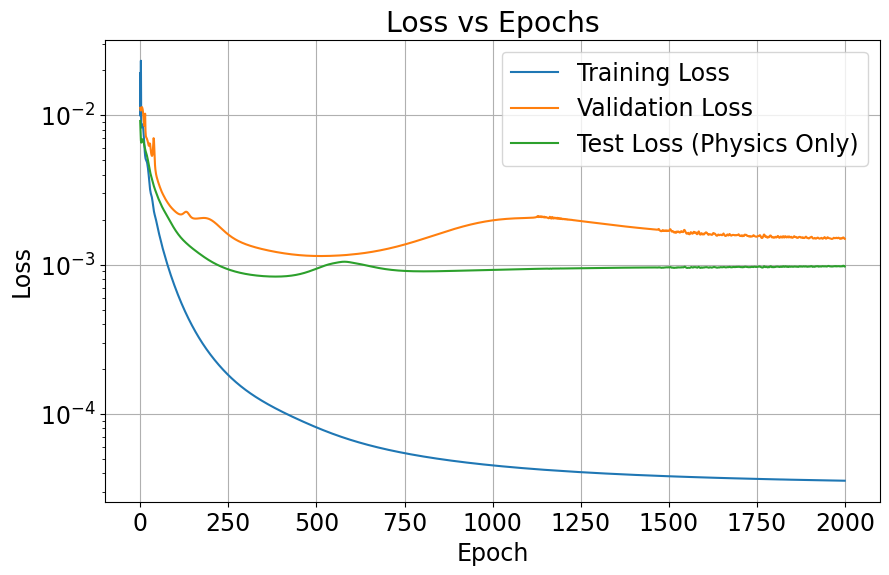

Validation loss: 0.0014878262300044298 Data: 0.00028304074658080935 Phys: 0.0012047854252159595
Test loss (physics only): 0.0009720316738821566 Phys: 0.0009720316738821566


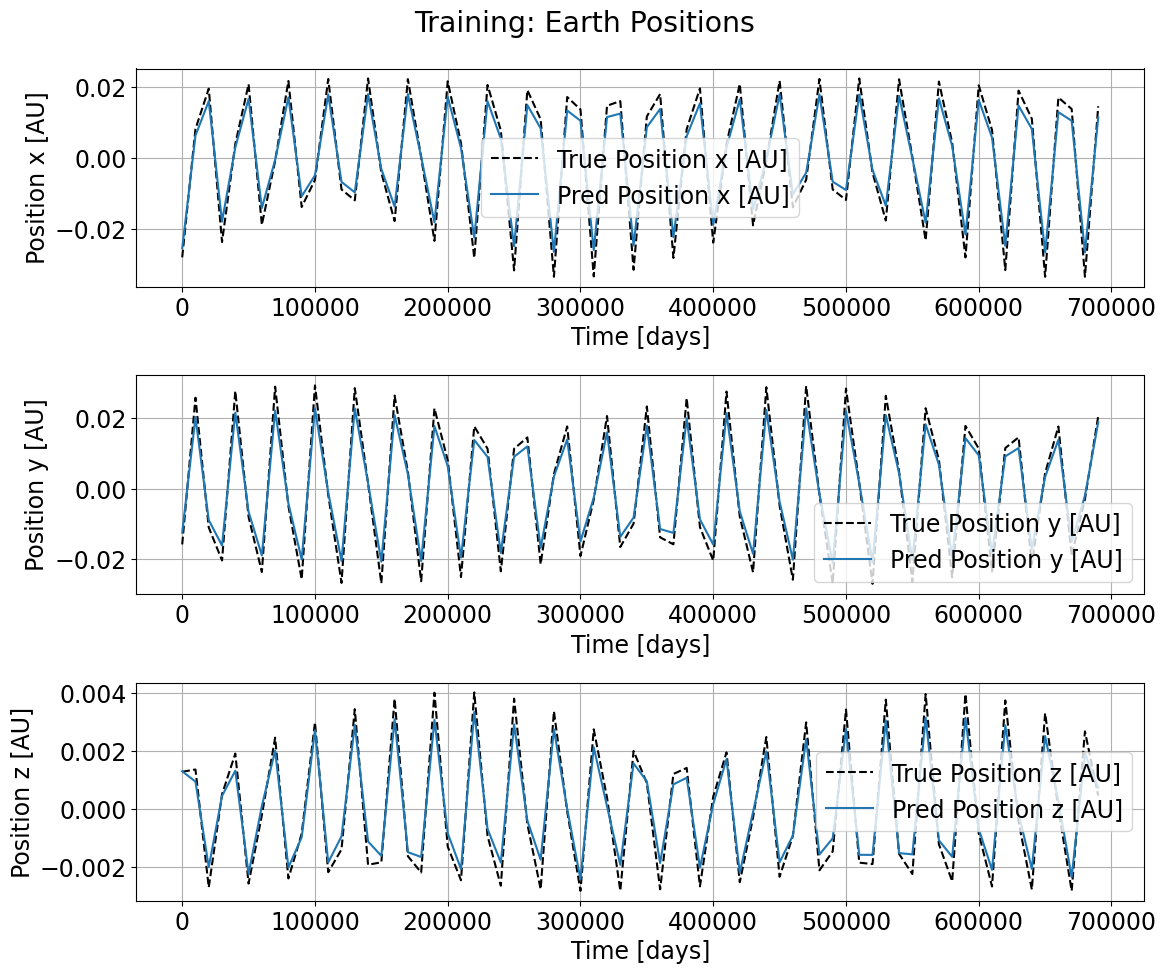

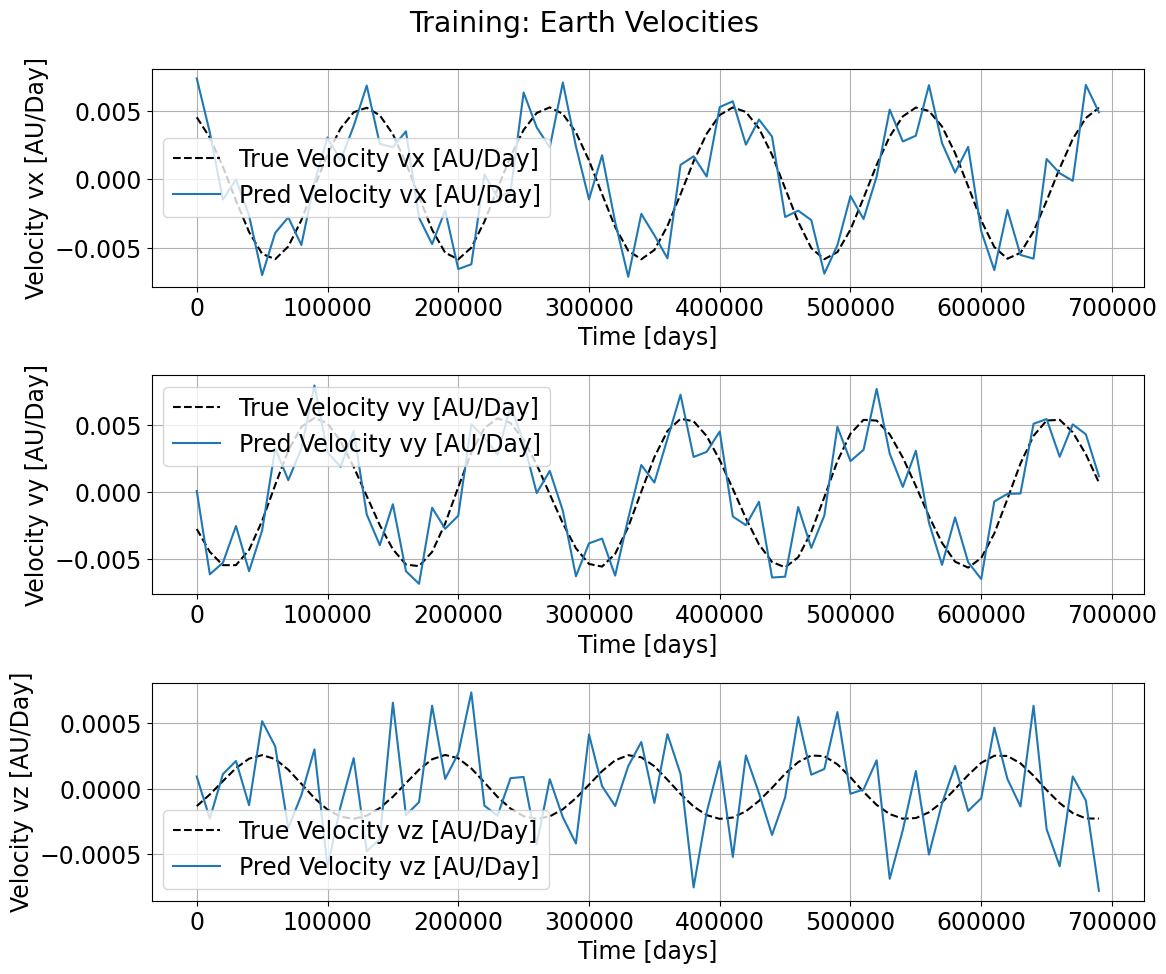

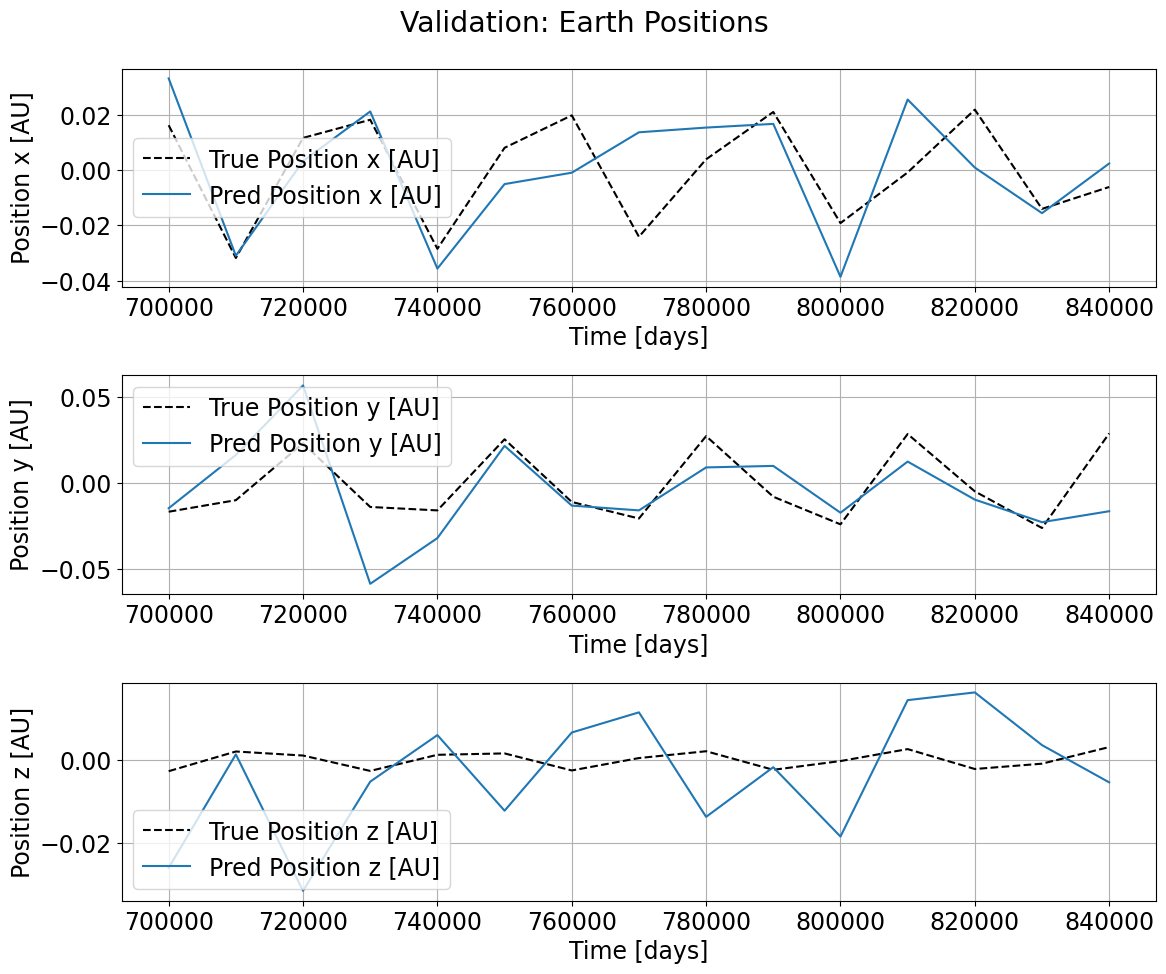

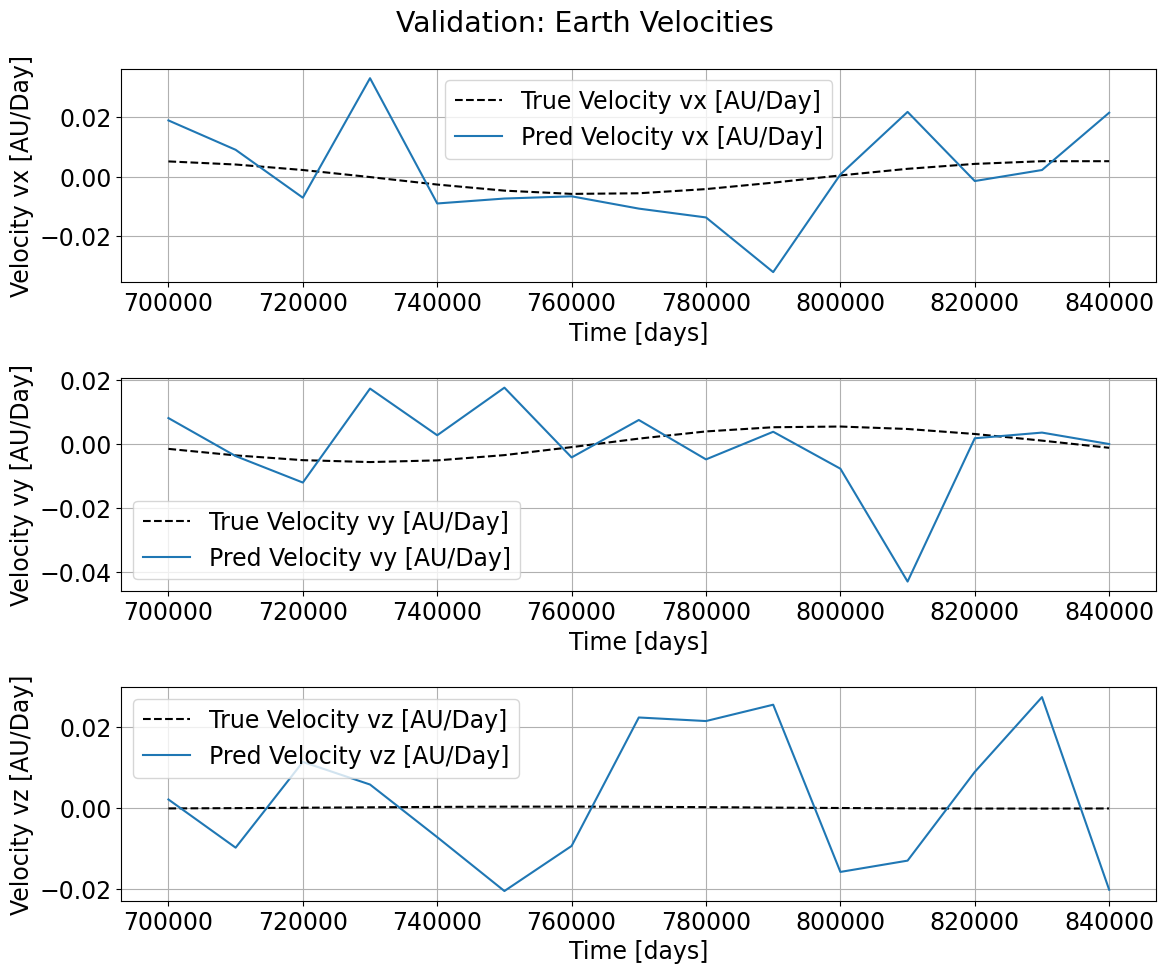

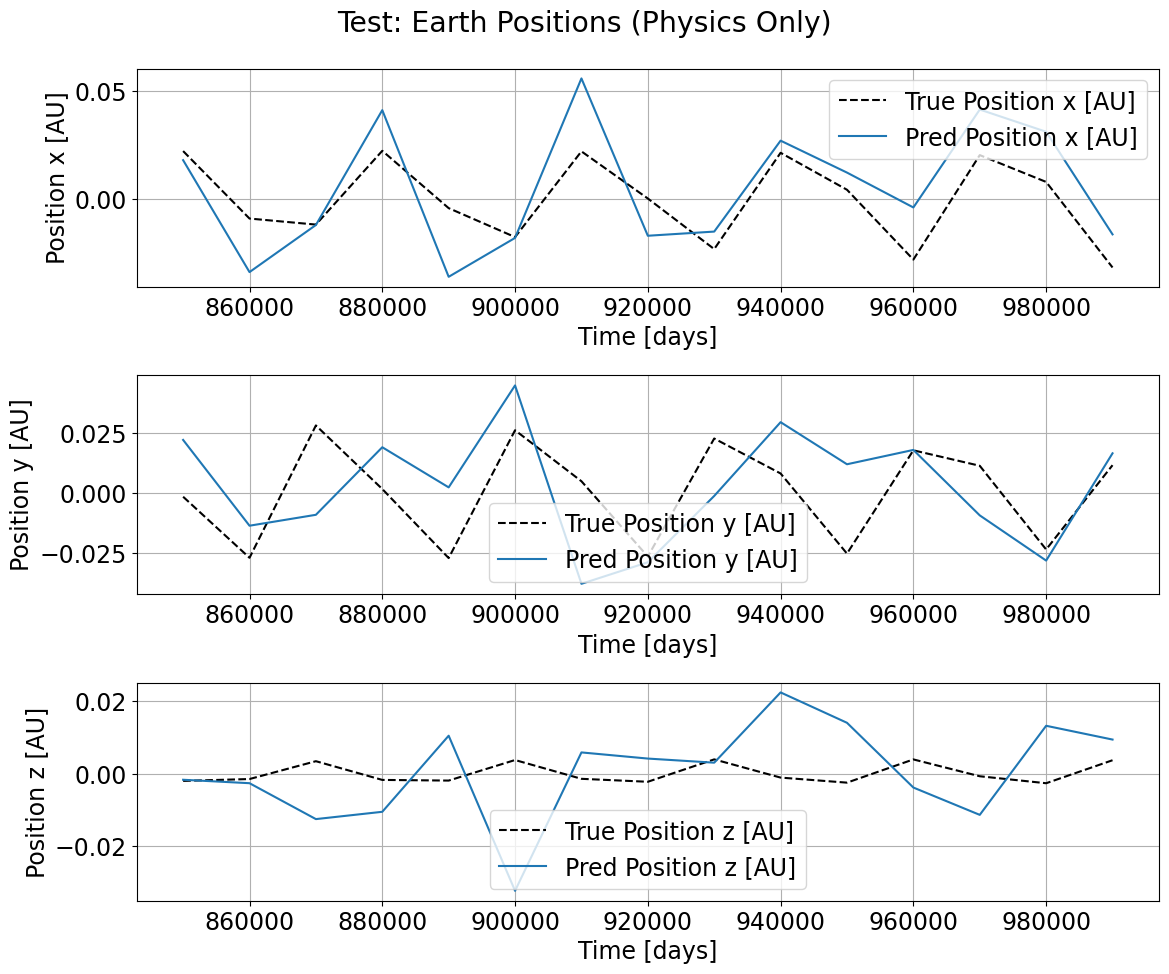

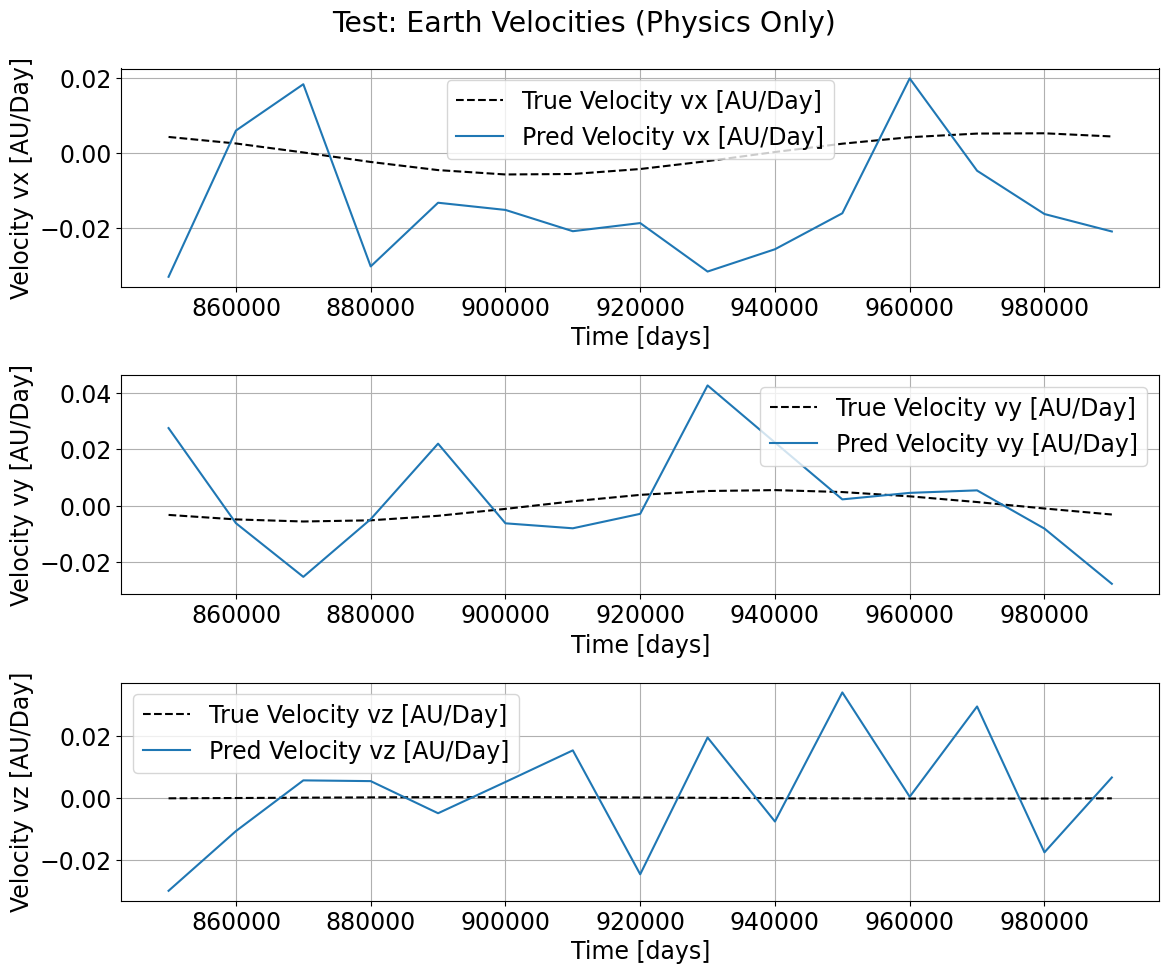

In [ ]:
X, Y = prepare_data(state_data, N, known_idx)

# Train/validation/test split
n_samples = len(X)
train_frac, val_frac, test_frac = 0.7, 0.15, 0.15
n_train = int(n_samples * train_frac)
n_val = int(n_samples * val_frac)

indices = np.arange(n_samples)

train_idx = indices[:n_train]
val_idx   = indices[n_train:n_train+n_val]
test_idx  = indices[n_train+n_val:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val     = X[val_idx], Y[val_idx]
X_test, Y_test   = X[test_idx], Y[test_idx]  # test uses physics loss only

t_train = t_data[train_idx]
t_val   = t_data[val_idx]
t_test  = t_data[test_idx]

# Initialize model
input_dim = X.shape[1]
output_dim = Y.shape[1]
model = PINN_NBody(input_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop with validation/test loss logging
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

epochs = 2000
train_loss_history = []
val_loss_history = []
test_loss_history = []

# evaluation
def evaluate(model, X, Y, λ_phys=1.0, data_loss=True):
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        Y_tensor = torch.tensor(Y, dtype=torch.float32)
        y_pred = model(X_tensor)
        loss, loss_data, loss_phys = model.loss_fn(y_pred, Y_tensor, earth_idx, N, masses, G, λ_phys=λ_phys, data_loss=data_loss)
    return y_pred.numpy(), loss.item(), loss_data.item(), loss_phys.item()

for epoch in range(epochs):
    # Training step
    optimizer.zero_grad()
    y_pred_train = model(X_train_tensor)
    loss_train, _, _ = model.loss_fn(y_pred_train, Y_train_tensor, earth_idx, N, masses, G, λ_phys=1.0, data_loss=True)
    loss_train.backward()
    optimizer.step()
    
    train_loss_history.append(loss_train.item())
    
    # Validation loss (data loss + physics loss)
    y_val_pred, val_loss, _, _ = evaluate(model, X_val, Y_val, data_loss=True)
    val_loss_history.append(val_loss)
    
    # Test loss (physics loss only)
    y_test_pred, test_loss, _, _ = evaluate(model, X_test, Y_test, data_loss=False)
    test_loss_history.append(test_loss)
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Train={loss_train.item():.3e}, Val={val_loss:.3e}, Test={test_loss:.3e}")
plt.rcParams.update({'font.size': 17}) 
# Plot training, validation, test loss
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss (Physics Only)')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


# Validation evaluation (data loss +physics loss)
y_val_pred, val_loss, val_data_loss, val_phys_loss = evaluate(model, X_val, Y_val, data_loss=True)
print("Validation loss:", val_loss, "Data:", val_data_loss, "Phys:", val_phys_loss)


# Test evaluation (physics loss only)
y_test_pred, test_loss, test_data_loss, test_phys_loss = evaluate(model, X_test, Y_test, data_loss=False)
print("Test loss (physics only):", test_loss, "Phys:", test_phys_loss)

# for plotting
def plot_earth(t, y_true, y_pred, p_or_v, title="Earth"):
    fig, axs = plt.subplots(3,1,figsize=(12,10))
    if p_or_v == 'position':
        components = ["Position x [AU]", "Position y [AU]", "Position z [AU]"]
    else:
        components = ["Velocity vx [AU/Day]", "Velocity vy [AU/Day]", "Velocity vz [AU/Day]"]

    for i, comp in enumerate(components):
        axs[i].plot(t, y_true[:,i], 'k--', label=f"True {comp}")
        axs[i].plot(t, y_pred[:,i], label=f"Pred {comp}")
        axs[i].set_xlabel("Time [days]")
        axs[i].set_ylabel(f"{comp}")
        axs[i].legend()
        axs[i].grid(True)
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Predict Earth on training set
y_train_pred, _, _, _ = evaluate(model, X_train, Y_train, data_loss=True)

earth_pos_train_true = Y_train[:, earth_idx*3:(earth_idx+1)*3]
earth_pos_train_pred = y_train_pred[:, earth_idx*3:(earth_idx+1)*3]

earth_vel_train_true = Y_train[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]
earth_vel_train_pred = y_train_pred[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]

# Plot Earth positions for training set
plot_earth(t_train, earth_pos_train_true, earth_pos_train_pred, p_or_v = "position", title="Training: Earth Positions")

# Plot Earth velocities for training set
plot_earth(t_train, earth_vel_train_true, earth_vel_train_pred, p_or_v = "velocity", title="Training: Earth Velocities")

# Validation plots
earth_pos_val_true = Y_val[:, earth_idx*3:(earth_idx+1)*3]
earth_pos_val_pred = y_val_pred[:, earth_idx*3:(earth_idx+1)*3]
plot_earth(t_val, earth_pos_val_true, earth_pos_val_pred, p_or_v = "position", title="Validation: Earth Positions")

earth_vel_val_true = Y_val[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]
earth_vel_val_pred = y_val_pred[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]
plot_earth(t_val, earth_vel_val_true, earth_vel_val_pred, p_or_v = "velocity", title="Validation: Earth Velocities")

# Test plots (physics only)
earth_pos_test_true = Y_test[:, earth_idx*3:(earth_idx+1)*3]
earth_pos_test_pred = y_test_pred[:, earth_idx*3:(earth_idx+1)*3]
plot_earth(t_test, earth_pos_test_true, earth_pos_test_pred, p_or_v = "position", title="Test: Earth Positions (Physics Only)")

earth_vel_test_true = Y_test[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]
earth_vel_test_pred = y_test_pred[:, 3*N + earth_idx*3:3*N + (earth_idx+1)*3]
plot_earth(t_test, earth_vel_test_true, earth_vel_test_pred, p_or_v = "velocity", title="Test: Earth Velocities (Physics Only)")
